# PenDigits Demo

Demo for unsupervised brute force shaplets searching for anomaly detection 

In [1]:
import os
os.chdir('/home/ludovicobartoli/Documents/Shapelets/')
print(os.getcwd())

import numpy as np
import random
import torch
from torch import tensor

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.SVDD.SVDD import SVDD
from src.util import Scaler, euclidean_distance_shifted, length_normalized_distance, max_corr, get_weights_via_kmeans
from src.learning.learningextractor import LearningShapelets 
from src.searching.bruteforce_multivariate import Bruteforce_extractor_mv, Candidateset
from src.searching.RLS import RLS_extractor, RLS_candidateset

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


/home/ludovicobartoli/Documents/Shapelets


/opt/anaconda3/envs/ludo_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up the dataset

### Load the data

Download the data (if needed):

In [2]:
data_name = "PenDigits"

# X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)
# np.save(f'../demo/data/{data_name}_train', X_train)
# np.save(f'../demo/data/{data_name}_train_labels', y_train)
# np.save(f'../demo/data/{data_name}_test', X_test)
# np.save(f'../demo/data/{data_name}_test_labeles', y_test)

X_train = np.load(f'demo/data/{data_name}_train.npy')
y_train = np.load(f'demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'demo/data/{data_name}_test.npy')
y_test = np.load(f'demo/data/{data_name}_test_labeles.npy')

print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

Shape of training data: (7494, 8, 2)
Shape of test data: (3498, 8, 2)
The different classes: {'1', '6', '7', '9', '3', '0', '5', '8', '4', '2'}


### Preprocessing

#### Get statistics of the entire data:

In [3]:
X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

# use label encoder to transform the labels from strings to integers
n_class = len(obs_perclass)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
print('The positions are the new labels', le.classes_)

Shape of the total data: (10992, 8, 2)
Number of total samples in each class: [1143, 1056, 1142, 1055, 1055, 1143, 1055, 1055, 1144, 1144]
The positions are the new labels ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Plot one sample per class:

/home/ludovicobartoli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  del sys.path[0]
/home/ludovicobartoli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/home/ludovicobartoli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  del sys.path[0]
/home/ludovicobartoli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_tic

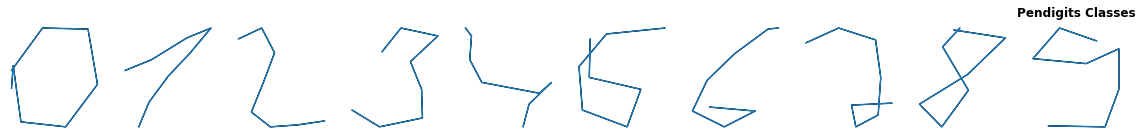

In [4]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
plt.title('Pendigits Classes', fontweight="bold")
# Plot shapelet and minimizer
for i in range(10):
    t = X_train[y_train==i][0]
    ax[i].plot(t[:, 0], t[:, 1])
    # Add an arrow
    xdata, ydata = t[:, 0], t[:, 1]
    for arw_i in range(7):
        ax[i].arrow(xdata[arw_i], ydata[arw_i], xdata[arw_i+1]-xdata[arw_i], ydata[arw_i+1]-ydata[arw_i], 
                 length_includes_head=True, head_width=0.09, color='black', overhang=0.12)

    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].axis('off')
plt.show()
# plt.savefig('pendigits_classes')

#### Create anomaly detection dataset:

In [5]:
# Set seed for determinism
np.random.seed(0)


X_train = X_train[np.logical_or(y_train==5, y_train==6)]
y_train = y_train[np.logical_or(y_train==5, y_train==6)]

X_test = X_test[np.logical_or(y_test==5, y_test==6)]
y_test = y_test[np.logical_or(y_test==5, y_test==6)]

# Set up anomaly detection dataset

normal_class = 5 # choose the normal class
normal_prop = 0.8 # proportion of normal samples that go in train set
alpha = 0 # proportion of anomalies wrt normal 
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class=normal_class, normal_prop=normal_prop)

N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of anomalous train series:', len(y_train_anomaly[y_train_anomaly==-1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))
print('number of anomalous test series:', len(y_test_anomaly[y_test_anomaly==-1]))


PenDigits dataset
number train ts is 844, each of length 8
They belong to two possible classes: {1}
number test ts 1267
number of normal train series: 844
number of anomalous train series: 0
number of normal test series: 211
number of anomalous test series: 1056


#### Normalize using MinMax scaler:

In [6]:
# normalize the time series
# as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.transform(X_test_anomaly)

#### Plot train and test set

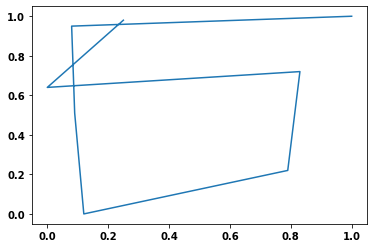

In [7]:
t = X_train_anomaly[y_train_anomaly==1][56]
plt.figure()
plt.plot(t[:, 0], t[:, 1], label='digit')
# plt.savefig('digit')
plt.show()


## ADSL algorithm 

Initialize using K-means clusters' centers:

Initial shape of clusters centers (1, 4, 2)
Type and shape of the shapelets in output <class 'numpy.ndarray'> (1, 4, 2)


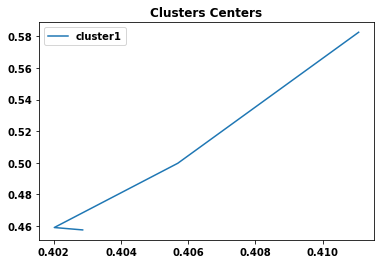

The shape of cluster centers is (1, 2, 4)


In [8]:
K_star = 1/Q 
L_star = 4/Q
L = round(L_star*Q) # length 
K = round(K_star*Q) # number of shapelets
clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=10000)
print(f'Initial shape of clusters centers {clusters_centers.shape}')

S_init = clusters_centers
print('Type and shape of the shapelets in output', type(S_init),  S_init.shape)

plt.figure()
for i in range(len(S_init)):
    shap = S_init[i,:,]
    plt.plot(shap[:,0], shap[:,1], label=f'cluster{i+1}')
plt.legend()
plt.title('Clusters Centers', fontweight="bold")
plt.show()

# function set_shapelet_weights() needs input of shape (num_shapelets, in_channels, len_shapelets)
clusters_centers = clusters_centers.transpose(0,2,1)
print(f'The shape of cluster centers is {clusters_centers.shape}')

Set up the learning extractor:

In [11]:
nu = len(X_train_anomaly[y_train_anomaly==-1]) / N
# C = 1 / (N * nu)
C = 1
extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=n_channels, C=C, verbose=1, to_cuda=True)
extractor.set_shapelet_weights(clusters_centers)

lr = 1e-1
optimizer = torch.optim.Adagrad(extractor.model.parameters(), lr=lr)

extractor.set_optimizer(optimizer)
n_epoch_steps = 100
n_epochs = 1
# total epochs = n_epoch_steps * n_epochs
batch_size = N

# Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
X_train_tensor = tensor(X_train_anomaly, dtype=torch.float).contiguous().transpose(1,2).cuda()

X = extractor.transform(X_train_tensor).reshape((N,1)) # numpy array shape (n_samples, n_shapelets)

svdd = SVDD(C=C, zero_center=True, verbose=True, tol=1e-8)
svdd.fit(X)
extractor.loss_func.update_r(svdd.radius)

10 support vectors out of 844 points
Solution found with center in 0.0 and radius 1.5432112216949463


In [12]:
losses = [extractor.loss_func(extractor.model(X_train_tensor)).item()]
print(losses)

[1.4154627323150635]


Train loop:

Epoch: 0
radius 1.5183883


Loss dist: 1.4154627323150635: 100%|██████████| 1/1 [00:00<00:00, 72.72it/s]

Epoch: 1


radius 1.2889459


Loss dist: 1.165574550628662: 100%|██████████| 1/1 [00:00<00:00, 102.55it/s]

Epoch: 2


radius 1.1416996


Loss dist: 1.0031453371047974: 100%|██████████| 1/1 [00:00<00:00, 110.91it/s]

Epoch: 3


radius 1.0710367


Loss dist: 0.8821921348571777: 100%|██████████| 1/1 [00:00<00:00, 110.79it/s]

Epoch: 4


radius 1.0638851


Loss dist: 0.7861065864562988: 100%|██████████| 1/1 [00:00<00:00, 122.39it/s]

Epoch: 5


radius 0.92154634


Loss dist: 0.7046828866004944: 100%|██████████| 1/1 [00:00<00:00, 119.43it/s]

Epoch: 6


radius 0.8143482


Loss dist: 0.6414691209793091: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

Epoch: 7


radius 0.84299815


Loss dist: 0.5468621253967285: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]

Epoch: 8


radius 0.7592004


Loss dist: 0.504081130027771: 100%|██████████| 1/1 [00:00<00:00, 120.27it/s]

Epoch: 9


radius 0.70498884


Loss dist: 0.465658575296402: 100%|██████████| 1/1 [00:00<00:00, 120.16it/s]

Epoch: 10


radius 0.7082427


Loss dist: 0.41704338788986206: 100%|██████████| 1/1 [00:00<00:00, 120.84it/s]

Epoch: 11


radius 0.6694765


Loss dist: 0.3930150270462036: 100%|██████████| 1/1 [00:00<00:00, 109.55it/s]

Epoch: 12


radius 0.63289154


Loss dist: 0.3756144046783447: 100%|██████████| 1/1 [00:00<00:00, 108.80it/s]

Epoch: 13


radius 0.53790945


Loss dist: 0.4030604958534241: 100%|██████████| 1/1 [00:00<00:00, 120.70it/s]

Epoch: 14


radius 0.5772343


Loss dist: 0.3570566475391388: 100%|██████████| 1/1 [00:00<00:00, 119.69it/s]

Epoch: 15


radius 0.5640668


Loss dist: 0.3533627986907959: 100%|██████████| 1/1 [00:00<00:00, 120.92it/s]

Epoch: 16


radius 0.562718


Loss dist: 0.3473866879940033: 100%|██████████| 1/1 [00:00<00:00, 120.75it/s]

Epoch: 17


radius 0.51364064


Loss dist: 0.37216639518737793: 100%|██████████| 1/1 [00:00<00:00, 127.46it/s]

Epoch: 18


radius 0.56824446


Loss dist: 0.3380106985569: 100%|██████████| 1/1 [00:00<00:00, 120.52it/s]

Epoch: 19


radius 0.57281244


Loss dist: 0.33460959792137146: 100%|██████████| 1/1 [00:00<00:00, 120.86it/s]

Epoch: 20


radius 0.5762479


Loss dist: 0.3323409855365753: 100%|██████████| 1/1 [00:00<00:00, 120.57it/s]

Epoch: 21


radius 0.57820606


Loss dist: 0.3309907913208008: 100%|██████████| 1/1 [00:00<00:00, 119.63it/s]

Epoch: 22


radius 0.5800286


Loss dist: 0.32986295223236084: 100%|██████████| 1/1 [00:00<00:00, 118.61it/s]

Epoch: 23


radius 0.580897


Loss dist: 0.329319030046463: 100%|██████████| 1/1 [00:00<00:00, 109.27it/s]

Epoch: 24


radius 0.5815282


Loss dist: 0.32896292209625244: 100%|██████████| 1/1 [00:00<00:00, 119.51it/s]

Epoch: 25


radius 0.5820348


Loss dist: 0.328701913356781: 100%|██████████| 1/1 [00:00<00:00, 120.18it/s]

Epoch: 26


radius 0.5823248


Loss dist: 0.3285517394542694: 100%|██████████| 1/1 [00:00<00:00, 119.32it/s]

Epoch: 27


radius 0.5826262


Loss dist: 0.328403115272522: 100%|██████████| 1/1 [00:00<00:00, 108.57it/s]

Epoch: 28


radius 0.5830763


Loss dist: 0.328189492225647: 100%|██████████| 1/1 [00:00<00:00, 120.45it/s]

Epoch: 29


radius 0.5830413


Loss dist: 0.3281925916671753: 100%|██████████| 1/1 [00:00<00:00, 120.61it/s]

Epoch: 30


radius 0.5831229


Loss dist: 0.3281542658805847: 100%|██████████| 1/1 [00:00<00:00, 109.18it/s]

Epoch: 31


radius 0.5831969


Loss dist: 0.32812127470970154: 100%|██████████| 1/1 [00:00<00:00, 121.08it/s]

Epoch: 32


radius 0.58324575


Loss dist: 0.32809990644454956: 100%|██████████| 1/1 [00:00<00:00, 123.99it/s]

Epoch: 33


radius 0.58325154


Loss dist: 0.3280971944332123: 100%|██████████| 1/1 [00:00<00:00, 119.62it/s]

Epoch: 34


radius 0.53460914


Loss dist: 0.3527463674545288: 100%|██████████| 1/1 [00:00<00:00, 120.80it/s]

Epoch: 35


radius 0.5824849


Loss dist: 0.32845887541770935: 100%|██████████| 1/1 [00:00<00:00, 120.35it/s]

Epoch: 36


radius 0.58293647


Loss dist: 0.32823503017425537: 100%|██████████| 1/1 [00:00<00:00, 121.62it/s]

Epoch: 37


radius 0.5831125


Loss dist: 0.32815662026405334: 100%|██████████| 1/1 [00:00<00:00, 120.52it/s]

Epoch: 38


radius 0.5831707


Loss dist: 0.3281311094760895: 100%|██████████| 1/1 [00:00<00:00, 121.01it/s]

Epoch: 39


radius 0.583196


Loss dist: 0.32812023162841797: 100%|██████████| 1/1 [00:00<00:00, 121.55it/s]

Epoch: 40


radius 0.5832064


Loss dist: 0.3281157314777374: 100%|██████████| 1/1 [00:00<00:00, 120.80it/s]

Epoch: 41


radius 0.58321387


Loss dist: 0.32811254262924194: 100%|██████████| 1/1 [00:00<00:00, 123.07it/s]

Epoch: 42


radius 0.5832185


Loss dist: 0.32811054587364197: 100%|██████████| 1/1 [00:00<00:00, 120.22it/s]

Epoch: 43


radius 0.5832218


Loss dist: 0.32810914516448975: 100%|██████████| 1/1 [00:00<00:00, 109.15it/s]

Epoch: 44


radius 0.583224


Loss dist: 0.32810819149017334: 100%|██████████| 1/1 [00:00<00:00, 119.68it/s]

Epoch: 45


radius 0.58322555


Loss dist: 0.3281075358390808: 100%|██████████| 1/1 [00:00<00:00, 120.72it/s]

Epoch: 46


radius 0.5832266


Loss dist: 0.3281071186065674: 100%|██████████| 1/1 [00:00<00:00, 120.27it/s]

Epoch: 47


radius 0.5832274


Loss dist: 0.32810676097869873: 100%|██████████| 1/1 [00:00<00:00, 119.83it/s]

Epoch: 48


radius 0.5832279


Loss dist: 0.328106552362442: 100%|██████████| 1/1 [00:00<00:00, 119.72it/s]

Epoch: 49


radius 0.5832283


Loss dist: 0.3281063735485077: 100%|██████████| 1/1 [00:00<00:00, 110.18it/s]

Epoch: 50


radius 0.5832285


Loss dist: 0.3281062841415405: 100%|██████████| 1/1 [00:00<00:00, 108.20it/s]

Epoch: 51


radius 0.5832287


Loss dist: 0.32810619473457336: 100%|██████████| 1/1 [00:00<00:00, 119.85it/s]

Epoch: 52


radius 0.5832288


Loss dist: 0.3281061053276062: 100%|██████████| 1/1 [00:00<00:00, 119.88it/s]

Epoch: 53


radius 0.5832289


Loss dist: 0.3281061053276062: 100%|██████████| 1/1 [00:00<00:00, 120.53it/s]

Epoch: 54


radius 0.58322895


Loss dist: 0.3281061351299286: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s]

Epoch: 55


radius 0.58322906


Loss dist: 0.3281060457229614: 100%|██████████| 1/1 [00:00<00:00, 121.05it/s]

Epoch: 56


radius 0.58322906


Loss dist: 0.3281060457229614: 100%|██████████| 1/1 [00:00<00:00, 119.86it/s]

Epoch: 57


radius 0.5832291


Loss dist: 0.32810601592063904: 100%|██████████| 1/1 [00:00<00:00, 119.98it/s]

Epoch: 58


radius 0.5832291


Loss dist: 0.32810601592063904: 100%|██████████| 1/1 [00:00<00:00, 121.11it/s]

Epoch: 59


radius 0.5832291


Loss dist: 0.32810601592063904: 100%|██████████| 1/1 [00:00<00:00, 120.86it/s]

Epoch: 60


radius 0.5832292


Loss dist: 0.32810601592063904: 100%|██████████| 1/1 [00:00<00:00, 121.27it/s]

Epoch: 61


radius 0.5832291


Loss dist: 0.3281060457229614: 100%|██████████| 1/1 [00:00<00:00, 120.56it/s]

Epoch: 62


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.15it/s]

Epoch: 63


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 109.10it/s]

Epoch: 64


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.53it/s]

Epoch: 65


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 109.04it/s]

Epoch: 66


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 119.47it/s]

Epoch: 67


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.56it/s]

Epoch: 68


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.56it/s]

Epoch: 69


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 106.73it/s]

Epoch: 70


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.32it/s]

Epoch: 71


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 108.71it/s]

Epoch: 72


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 109.14it/s]

Epoch: 73


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.73it/s]

Epoch: 74


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 121.85it/s]

Epoch: 75


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 121.45it/s]

Epoch: 76


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.60it/s]

Epoch: 77


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 121.85it/s]

Epoch: 78


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.07it/s]

Epoch: 79


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 109.39it/s]

Epoch: 80


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.78it/s]

Epoch: 81


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 119.81it/s]

Epoch: 82


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 119.80it/s]

Epoch: 83


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.69it/s]

Epoch: 84


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.31it/s]

Epoch: 85


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.95it/s]

Epoch: 86


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 119.19it/s]

Epoch: 87


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 108.89it/s]

Epoch: 88


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 108.99it/s]

Epoch: 89


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 119.22it/s]

Epoch: 90


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.73it/s]

Epoch: 91


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.73it/s]

Epoch: 92


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 119.71it/s]

Epoch: 93


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 109.43it/s]

Epoch: 94


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.47it/s]

Epoch: 95


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.01it/s]

Epoch: 96


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 120.38it/s]

Epoch: 97


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 118.85it/s]

Epoch: 98


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 119.96it/s]

Epoch: 99


radius 0.5832292


Loss dist: 0.32810598611831665: 100%|██████████| 1/1 [00:00<00:00, 119.73it/s]


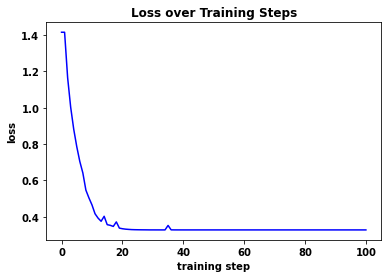

In [13]:
for epoch in range(n_epoch_steps):
    print(f'Epoch: {epoch}')
    X = extractor.transform(X_train_tensor).reshape((N,1)) # numpy array shape (n_samples, n_shapelets)
    
    svdd = SVDD(C=C, zero_center=True, verbose=False, tol=1e-9)
    svdd.fit(X)
    extractor.loss_func.update_r(svdd.radius)
    print('radius', extractor.loss_func.get_radius())
    losses += extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)

plt.figure()
plt.plot(losses, color='blue')
plt.title("Loss over Training Steps", fontweight="bold")
plt.xlabel("training step")
plt.ylabel("loss")
plt.show()
# plt.savefig('loss')

Plot the shapelet against a time series:

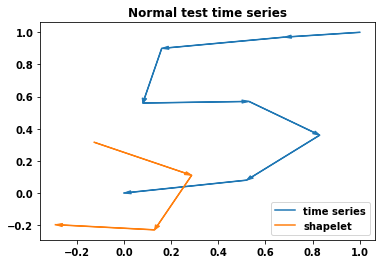

In [14]:
S = extractor.get_shapelets()
# use moveaxis because the shapelets returned have shape (num_shapelets, in_channels, shapelets_size)
S = np.moveaxis(S, 1, 2)

plt.figure()
for i in range(len(S)):
    t = X_train_anomaly[y_train_anomaly==1][67]
    plt.plot(t[:,0], t[:,1], label='time series')
    xdata, ydata = t[:, 0], t[:, 1]
    for arw_i in range(7):
        plt.arrow(xdata[arw_i], ydata[arw_i], xdata[arw_i+1]-xdata[arw_i], ydata[arw_i+1]-ydata[arw_i], 
                 length_includes_head=True, head_width=0.02, color='tab:blue', overhang=0.04)
    shap = S[i,:,]
    plt.plot(shap[:,0], shap[:,1], label=f'shapelet')
    xdata, ydata = shap[:, 0], shap[:, 1]
    for arw_i in range(3):
        plt.arrow(xdata[arw_i], ydata[arw_i], xdata[arw_i+1]-xdata[arw_i], ydata[arw_i+1]-ydata[arw_i], 
                 length_includes_head=True, head_width=0.02, color='tab:orange', overhang=0.04)
plt.legend()
plt.title('Normal test time series', fontweight="bold")
plt.show()
# plt.savefig('pendigits_normal')

## Anomaly detection using SVDD

Transform the dataset:

In [19]:
# tranform method takes in input a tensor of shape (n_samples, in_channels, len_ts) 
# and outputs a numpy array of shape (n_samples, n_shapelets)
X_train_transform = extractor.transform(X_train_tensor).reshape((N,1))

X_test_tensor = tensor(X_test_anomaly, dtype=torch.float).contiguous().transpose(1,2)
X_test_transform = extractor.transform(X_test_tensor).reshape((len(X_test_anomaly),1))

# check if type and shape are correct:
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

svdd = SVDD(C=C, zero_center=True, tol=1e-8)

# fit the model
svdd.fit(X_train_transform)

Type and shape of transformed train data <class 'numpy.ndarray'> (844, 1)
Type and shape of transformed test data <class 'numpy.ndarray'> (1267, 1)
2 support vectors out of 844 points
Solution found with center in 0.0 and radius 0.5832291841506958


EVALUATE the prediction:

In [20]:
# BALANCED ACCURACY
y_test_predict = svdd.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("Test balanced accuracy:", test_ba)

# AUC
y_test_scores = -svdd.decision_function(X_test_transform)
fpr, tpr, _ = roc_curve(y_test_anomaly, y_test_scores, pos_label=-1)
auc_test = auc(fpr, tpr)
print("Test AUC:", auc_test)

# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict, pos_label=-1)
print("Test F1 score:", f1_test)

Test balanced accuracy: 0.9659068469050696
Test AUC: 0.9977470199626598
Test F1 score: 0.9667644183773216


Confusion matrix

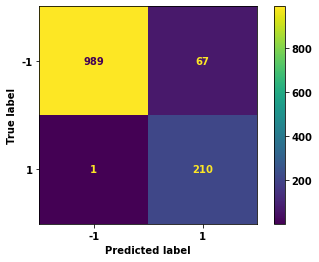

In [17]:
# Confusion matrix
cm = confusion_matrix(y_test_anomaly, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[-1,1]).plot()
plt.show()

ROC and overlapping histograms plot

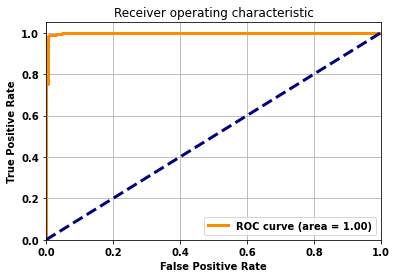

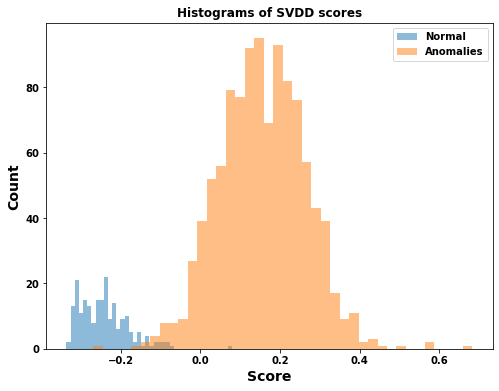

In [18]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test_anomaly, y_test_scores, pos_label=-1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=3, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()
# plt.savefig('ROC_test.png')

# OVERLAPPING HISTOGRAMS PLOT of SVDD scores (test data)

plt.figure(figsize=(8,6))
plt.hist(y_test_scores[y_test_anomaly==1], bins=40, alpha=0.5, label="Normal")
plt.hist(y_test_scores[y_test_anomaly==-1], bins=40, alpha=0.5, label="Anomalies")

plt.xlabel("Score", size=14)
plt.ylabel("Count", size=14)
plt.title("Histograms of SVDD scores", fontweight="bold")
plt.legend(loc='upper right')
plt.show()